# BoolForge Tutorial #6: Working with Boolean networks

In this tutorial, we will explore the `BooleanNetwork` class.
You will learn how to:
- create Boolean networks,
- compute basic properties of the underlying wiring diagram, and
- compute basic properties of the Boolean network.

In [1]:
import boolforge
import numpy as np
import networkx as nx

## Boolean network theory

A *Boolean network* $F=(f_1,\ldots,f_N)$ constitutes a popular modeling framework in systems biology. It consists of $N$ nodes (e.g., genes, proteins, etc.). Each node can only be in two states, 0 or 1. With biology in mind, these two states are often referred to as absence or OFF (e.g., low protein concentration) and presence or ON (e.g., high protein concentration), respectively. Each node $x_i$ in a Boolean network possesses a Boolean *update function* $f_i: \{0,1\}^N \to \{0,1\}$ (i.e., an instance of `BooleanFunction`), which describes the state of $x_i$ at the next time point given the current state of the system. 

Under a synchronous updating scheme, all nodes are updated simultaneously. In this case, $F: \{0,1\}^N \to \{0,1\}^N$ defines a deterministic state transition graph, which consists of the $2^N$ states $\mathbf x=(x_1,\ldots,x_n)\in \{0,1\}^N$ and their deterministically defined transitions. Asynchronous updating schemes allow for nodes to be updated separately, at potentially different time scales (Thomas & d'Ari, Biological feedback, 1990). In most schemes, only a single node is updated at a time. In this case, the state space is typically stochastic because $\mathbf x\in \{0,1\}^N$ may transition to $N$ different states $\mathbf  y\in \{0,1\}^N$, depending on which node $x_i$ is updated. `BoolForge` implements both a synchronous updating scheme and a general asynchronous updating scheme (each node is updated with equal probability (Harvey & Bossomaier, Proc 4th Eur. Conf. on Artificial Life, 1997), which has been established as the most efficient and informative asynchronous updating method (Saadatpour et al., Journal of Theoretical Biology, 2010).

While each update function $f_i$ may, in theory, depend on all $N$ inputs, real Boolean networks (e.g., gene regulatory network models) are frequently sparsely connected, i.e., each node is only regulated by one or a few nodes. The *in-degree* of node $x_i$ is defined as the number of essential variables of update function $f_i$. The *wiring diagram* (also known as *dependency graph*, *interaction matrix*, or *adjacency matrix*) of a Boolean network contains the $N$ nodes $x_1,\ldots,x_N$, and an edge from $x_i$ to $x_j$ if the update of $x_j$ depends on $x_i$, i.e., if $x_i$ is an essential variable of $f_j$.

## Wiring diagrams

To begin, we will learn how to create instances of the class `WiringDiagram`, which the class `BooleanNetwork` is built upon. To create a wiring diagram of $N$ nodes, it suffices to describe "who regulates who". That is, we must provide a list of N lists describing the indices of the regulators. If the ith list has length n, that means the ith variable is regulated by n variables. As an example, we define a wiring diagram on $N=3$ nodes.

W.N: 3
W.variables: ['x0' 'x1' 'x2']
W.indegrees: [1 2 1]
W.outdegrees: [1 2 1]
W.N_constants: 0
W.N_variables: 3


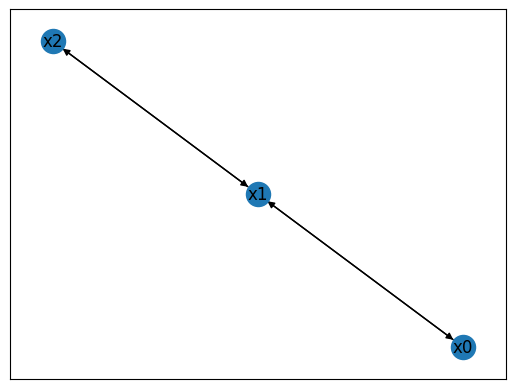

In [2]:
#Wiring diagram of a 3-node network
I = [[1],
     [0,2],
     [1]]

#Create an instance of WiringDiagram
W = boolforge.WiringDiagram(I=I)

#Print basic properties
print(f'W.N: {W.N}')
print(f'W.variables: {W.variables}')
print(f'W.indegrees: {W.indegrees}')
print(f'W.outdegrees: {W.outdegrees}')
print(f'W.N_constants: {W.N_constants}')
print(f'W.N_variables: {W.N_variables}')

#Plot the wiring diagram
DiGraph = W.generate_networkx_graph()
nx.draw_networkx(DiGraph, with_labels=True, arrows=True)

The code above creates and plots the wiring diagram. Since we did not provide the names of the variables (via optional argument `variables`), it used default variable names $x_0,\ldots,x_{N-1}$. Any instance of `WiringDiagram` also contains two vectors of length $N$:
- `indegrees` describes the number of incoming edges (i.e., the number of regulators) per node,
- `outdegrees` describes the number of outgoing edges per node (i.e., the number of nodes this node regulates).

It further contains two integers `N_constants` and `N_variables`, which together always sum up to $N$. The former counts the number of nodes that are constant (nodes with an indegree of 0). The later counts the number of nodes that are not constant, with an indegree $>0$.

The next example contains constants and also nodes, for which their indegree is not the same as their outdegree (note that the average indegree will always equal the average outdegree).

W.N: 3
W.variables: ['x0' 'x1' 'x2']
W.indegrees: [0 2 1]
W.outdegrees: [2 0 1]
W.N_constants: 1
W.N_variables: 2


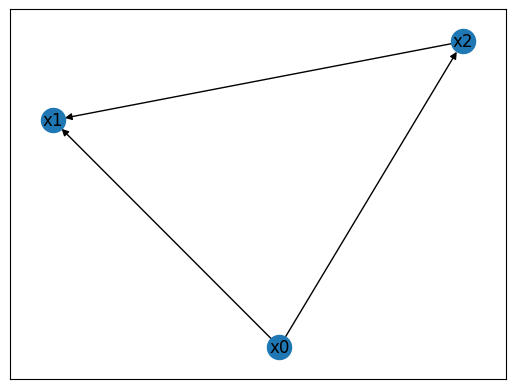

In [3]:
#Wiring diagram of a 3-node network
I = [[],
     [0,2],
     [0]]

#Create an instance of WiringDiagram
W = boolforge.WiringDiagram(I=I)

#Print basic properties
print(f'W.N: {W.N}')
print(f'W.variables: {W.variables}')
print(f'W.indegrees: {W.indegrees}')
print(f'W.outdegrees: {W.outdegrees}')
print(f'W.N_constants: {W.N_constants}')
print(f'W.N_variables: {W.N_variables}')

#Compute structural features
# print(f'Feedforward-loops: {W.get_ffls()}')


#Plot the wiring diagram
DiGraph = W.generate_networkx_graph()
nx.draw_networkx(DiGraph, with_labels=True, arrows=True)

This instance of `WiringDiagram` encodes a feed-forward loop, a common recurring pattern (*network motif*) found in biological networks. Node $x_0$ is constant and regulates $x_1$ and $x_2$. Node $x_2$ is also regulated by the intermediate node $x_1$.

## Create Boolean networks
 
To create a Boolean network of $N$ nodes from scratch, `BoolForge` requires, at a minimum, two inputs:
1. A list of N lists describing the indices of the regulators for each Boolean function. This defines the wiring diagram.
2. A list of N instances of `BooleanFunction` or a list of N binary vectors of length $2^n$ representing the outputs of a Boolean function with n inputs. This defines the specific update functions of each node.

In [6]:
#Wiring diagram of the 3-node network
I = [[1],
     [0,2],
     [1]]

#Boolean functions of a 3-node network
F = [[0,1],
     [0,1,1,1],
     [0,1]]

#Create instance of BooleanNetwork
bn = boolforge.BooleanNetwork(F=F, I=I)

#Print the entire truth table
bn.to_truth_table()

,x0(t),x1(t),x2(t),x0(t+1),x1(t+1),x2(t+1)
0,0,0,0,0,0,0
1,0,0,1,0,1,0
2,0,1,0,1,0,1
3,0,1,1,1,1,1
4,1,0,0,0,1,0
5,1,0,1,0,1,0
6,1,1,0,1,1,1
7,1,1,1,1,1,1


The full truth table of a Boolean network, as displayed above, is of size $2N \times 2^N$. In the worst case (in the case of a fully connected wiring diagram), F contains $N$ lists of length $2^N$. Since biological networks are sparsely connected with an average degree of about 2.5, storing only F and I is memory-effective.

Boolean networks can be created in a number of ways. For example, we can create the above network from a string:

In [5]:
string = '''x = y
y = x OR z
z = y'''

#Create instance of BooleanNetwork from string
cn = boolforge.BooleanNetwork.from_string(string,separator='=')

#Print the entire truth table
cn.to_truth_table()

,x(t),y(t),z(t),x(t+1),y(t+1),z(t+1)
0,0,0,0,0,0,0
1,0,0,1,0,1,0
2,0,1,0,1,0,1
3,0,1,1,1,1,1
4,1,0,0,0,1,0
5,1,0,1,0,1,0
6,1,1,0,1,1,1
7,1,1,1,1,1,1


This flexible string conversion method enables us to load Boolean networks from standard formats, such as the .bnet format, which uses comma to separate the node that is regulated from its regulatory function.

Boolean networks can also be loaded from an instance of cana.boolean_network.BooleanNetwork from the `CANA` package, and vice versa.

In [12]:
cana_bn = bn.to_cana()
bn_from_cana = boolforge.BooleanNetwork.from_cana(cana_bn)
assert (np.all([np.all(bn.F[i].f == bn_from_cana.F[i].f) for i in range(bn.N)]) and
        np.all([np.all(bn.I[i] == bn_from_cana.I[i]) for i in range(bn.N)]) and 
        np.all(bn.variables == bn_from_cana.variables)), 'failed BooleanNetwork.to_cana or BooleanNetwork.from_cana'

## Boolean networks with constants

There are three types of nodes in a Boolean network.
 - source nodes, which remain fixed over time.
 - constant nodes, which only take one value, 0 or 1.
 - regular nodes, which are regulated by at least one other node.

When a Boolean network is loaded, constant nodes are removed from the network to reduce its size. For each constant node, its value is passed on to all regular nodes that are regulated by this constant node.

In [11]:
F = [[0,0,0,1], #regular node
     [0,1,1,1], #regular node
     [0,1], #source node
     [0]] #constant node

I = [[1,2], #regular node
     [0,3], #regular node
     [2], #source node
     []] #constant node

bn = boolforge.BooleanNetwork(F,I)

print(f"bn.variables: {bn.variables}")
print(f"bn.constants: {bn.constants}")
print(f"bn.F: {bn.F}")
print(f"bn.I: {bn.I}")


bn.F: [BooleanFunction(f=[0, 0, 0, 1]), BooleanFunction(f=[0, 1]), BooleanFunction(f=[0, 1])]
bn.I: [array([1, 2]), array([0]), array([2])]
bn.variables: [np.str_('x0'), np.str_('x1'), np.str_('x2')]
bn.constants: {np.str_('x3'): {'value': 0, 'regulatedNodes': [np.str_('x1')]}}


Note that the constant node $x_3$, which is constant at 0, never appears among the variables. Instead, the value 0 is passed to the update rule of $x_1$, which then simplifies to $x_1(t+1) = x_0(t)$.

The passing of constant node values may cause other inputs to become irrelevant, which can be seen when considering a constant node $x_3=1$:

In [ ]:
F = [[0,0,0,1], #regular node
     [0,1,1,1], #regular node
     [0,1], #source node
     [1]] #constant node

I = [[1,2], #regular node
     [0,3], #regular node
     [2], #source node
     []] #constant node

bn = boolforge.BooleanNetwork(F,I)

print(f"bn.F: {bn.F}")
print(f"bn.I: {bn.I}")
print(f"bn.variables: {bn.variables}")

bn.F: [BooleanFunction(f=[0, 0, 0, 1]), BooleanFunction(f=[1, 1]), BooleanFunction(f=[0, 1])]
bn.I: [array([1, 2]), array([0]), array([2])]
bn.variables: [np.str_('x0'), np.str_('x1'), np.str_('x2')]


Now, $x_1 = 1$ irrespective of $x_0$. Importantly, $x_1$ cannot be treated as a constant node itself because setting $x_1=0$ is still a meaningful initial condition; If $x_1=0$, it will just never remain at this value.  

## Boolean network properties

The class `BooleanNetwork` inherits all the functionality of the class `WiringDiagram`. For example,

In [7]:
print(f'bn.N: {bn.N}')
print(f'bn.indegrees: {bn.indegrees}')
print(f'bn.outdegrees: {bn.outdegrees}')
print(f'bn.N_constants: {bn.N_constants}')
print(f'bn.N_variables: {bn.N_variables}')

bn.N: 3
bn.variables: ['x0' 'x1' 'x2']
bn.indegrees: [1 2 1]
bn.outdegrees: [1 2 1]
bn.N_constants: 0
bn.N_variables: 3


In the following tutorials, we will explore additional functionality, specifically related to structural and dynamical analysis. 